In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools

import tempfile
import six
import networkx as nx
import scipy.stats as sps
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg

from scipy.stats import mode
dy_name = 'evariant_length_analysis'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    DJ.makedir(private_out)



import gc

In [3]:
def add_svtype_cats(all_qtls_filt):
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV', 'SNV': 'SNV', 'INDEL_DEL': 'INDEL', 
               'INDEL_INS': 'INDEL'}
    all_qtls_filt['SVTYPE_SUPER'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'SV'))
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV',
               'ALU': 'MEI', 'LINE1': 'MEI', 'SVA':'MEI', 'rMEI':'rMEI', 
          'DUP': 'CNV', 'DEL': 'CNV', 'mCNV': 'CNV', 'SNV': 'SNV', 'INDEL_INS': 'INDEL', 'INDEL_DEL': 'INDEL', 
              'INDEL': 'INDEL', 'SNP': "SNV"}
    all_qtls_filt['SVTYPE_COLLAPSE'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'other SV'))
    convert = {'LINE1':'MEI', 'SVA': 'MEI', 'ALU': 'MEI'}
    all_qtls_filt['SVTYPE_NR_C'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x,x))
    
    convert = {'LINE1':'MEI', 'SVA': 'MEI', 'ALU': 'MEI', 'DUP': 'CNV', 'DEL': 'CNV', 'mCNV': 'CNV'}
    all_qtls_filt['SVTYPE_NR_C2'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x,x))
    
    
    
    
   
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV', 'INV': 'other SV', 'BND': 'other SV',
               'ALU': 'MEI', 'LINE1': 'MEI', 'SVA':'MEI', 'rMEI':'rMEI', 
          'DUP': 'DUP', 'DEL': 'DEL', 'mCNV': 'mCNV', 'SNV': 'SNV', 'INDEL_INS': 'INDEL', 'INDEL_DEL': 'INDEL', 
              'INDEL': 'INDEL', 'SNP': "SNV"}
    all_qtls_filt['SVTYPE_NR_C3'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x,x)) 
    
    
    
    return all_qtls_filt

In [46]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats_r = importr('stats')

# from rpy2.robjects.packages import importr
utils = importr('utils')

def add_bh_fdr(top, col):
    top = top.copy()
    p_vals = top[col].tolist()
    p_adjust = stats_r.p_adjust(FloatVector(p_vals), method = 'fdr')
    top['fdr_corrected_p'] = list(p_adjust)
    return top

In [20]:
def vc_to_or(vc, v = False):
    def default_loc(df, a, b, default = 0):
        try:
            out = df.loc[a,b]
            return out
        except:
            return default        
    if not v:
        
        t_g1 = [default_loc(vc, True, True), default_loc(vc, True, False)]
        f_g1 = [default_loc(vc, False, True), default_loc(vc, False, False)]
        v = [t_g1, f_g1]
    else:
        v = vc

    try:
        odds_ratio, p_fisher = sps.fisher_exact(v, )
    except:
        odds_ratio, p_fisher = (np.NaN, np.NaN) 
    return v, odds_ratio, p_fisher

In [31]:
def safe_div(a, b, is_null_out = 0):
    try:
        out = a/b
    except:
        out = is_null_out
    return out

In [32]:
def annotate_tests_data(df, col = "significant"):
    df = df.copy()
    def safe_div(a, b):
        try:
            out = a/b
        except:
            out = np.NaN
        return out
            
#     df['frac_non_{}_ol_feat'.format(col)] = df['{}_False'.format(col)].apply(lambda x: safe_div(x[1], x[0]))
#     df['frac_{}_ol_feat'.format(col)] =  df['{}_True'.format(col)].apply(lambda x: safe_div(x[1], x[0]))
    try:
        df['-log10p_fisher'] = np.log10(df['p_fisher']) * -1
    except:
        pass
    
    try:
        df['log_odds_ratio'] = np.log10(df['odds_ratio'])
    except:
        pass
    
    try:
        df['log2_odds_ratio'] = np.log2(df['odds_ratio'])
    except:
        pass
    df = df.reset_index()
    
    df['log2_odds_ratio_raw'] = df['log2_odds_ratio']
    
    
    t_neg_inf = df.log2_odds_ratio == (-np.inf)
    t_pos_inf = (df.log2_odds_ratio == (np.inf))
    
    exclude = t_neg_inf[t_neg_inf].index.tolist() + t_pos_inf[t_pos_inf].index.tolist()
    if len(exclude) > 0:
        inds_non_inf = set(df.index.tolist()).difference(exclude)

        if t_neg_inf[t_neg_inf].shape[0] > 0:
            inds = t_neg_inf[t_neg_inf].index.tolist()
            try:
                m = df.loc[inds_non_inf].log2_odds_ratio.min()
            except:
                m = -1
            
            if m >= -0.5:
                m = -1
            df.loc[inds, 'log2_odds_ratio'] = m
            
        if t_pos_inf[t_pos_inf].shape[0] > 0:
            inds = t_pos_inf[t_pos_inf].index.tolist()
            try:
                m = df.loc[inds_non_inf].log2_odds_ratio.max()
            except:
                m = 2
            if m < 0:
                m = 2
            df.loc[inds, 'log2_odds_ratio'] = m
            
    return df

In [6]:
var_egene_nr = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v4/var_egene_nr.pkl').pipe(add_svtype_cats)

In [13]:
per_var  = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/per_variant_info_annot_update.pkl').pipe(add_svtype_cats)

In [14]:
tdf = per_var[per_var.SVTYPE_NR.isin(['DEL', 'DUP', 'mCNV', 'STR'])]

In [ ]:
labs = []
for i, b in enumerate(bins[:-1]):
    low, high = bins[i:i +2]
    
#     bin_lab = "{}-{}".format(low +1, high)
    
    b = mpltools.format_base_pair_scale([low + 1,high])
    bin_lab = "{}-{}".format(b[0], b[1])
    labs.append(bin_lab)
    

labs[0] = '1bp'
# labs[-1] = '0.25MB+'
labs[-1] = '50kb+'

xval = dict(zip(labs, range(len(labs))))

tdf['bin_length'] = pd.cut(tdf.SVLEN, bins = bins, labels=labs)

tdf['bin_length_xval'] = tdf.bin_length.apply(lambda x: xval[x])

vc = tdf.groupby(('SVTYPE_NR', 'bin_length')).significant_association.value_counts(normalize = True).to_frame('fraction').reset_index()

vc['x'] = vc.bin_length.apply(lambda x: xval[x])

In [355]:
def gather_stats_length_enrichment(tdf, col = 'significant_association'):
    bins = [0,1, 3, 5, 10, 50, 200, 500, 900, 2000, 3500, 5000, 10000, 50000, 150000]

    # bins = np.arange(0, 1002, 2) + np.arange(1000, 150000, 1000)

    data = []
    svtypes = ['DEL', 'DUP', 'mCNV', 'STR']
    for svt in svtypes:
        for t in bins[:-1]:
            #         print t, svt
            tdf['in_cat'] = tdf.SVLEN >= t
            df = tdf[tdf.SVTYPE_NR == svt]
#             a = vin.to_frame('fraction')
            vin = df.groupby('in_cat')[col].value_counts()
#             b = vin.to_frame('num')
            v, odds_ratio, p_fisher = vc_to_or(vin)
            fraction = safe_div(v[0][0], sum(v[0]))
            data.append([v, odds_ratio, p_fisher, fraction, svt, t])
    stats_length = pd.DataFrame(data, columns=['contingency', 'odds_ratio', 'p_fisher', 'fraction', 'SVTYPE',
                                               'threshold']).pipe(annotate_tests_data)

    thresh_order = dict(zip(bins, range(len(bins))))
    thresh_labels = dict(zip(bins, ["{}+".format(i) for i in mpltools.format_base_pair_scale(bins)]))
    stats_length['x'] = stats_length.threshold.map(thresh_order)
    stats_length['xlabel'] = stats_length.threshold.map(thresh_labels)
    
    
    sl = stats_length[~((stats_length.threshold > 0) & (stats_length.odds_ratio.isnull()) & 
                    (stats_length.SVTYPE == "STR"))]
    sl['size'] = (sl['-log10p_fisher'] +1) * 50 
    sl['significant'] = sl.p_fisher < 0.05

    sl['ec'] = sl.significant.apply(lambda x: {True:'red', False: 'grey'}[x])
    sl['lw'] = sl.significant.apply(lambda x: {True:0.8, False: 0.2}[x])
    
    
    return stats_length, sl


In [331]:
class MidpointNormalize(mpl.colors.Normalize):
    """Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [356]:
stats_length, sl_plot = gather_stats_length_enrichment(tdf)

In [357]:
stats_length_lead, sl_plot_lead = gather_stats_length_enrichment(tdf, col  = 'lead_association')

In [358]:
CM.save_dataframe('enr_length_signif', stats_length, private_out, print_vars_recorded_loc=False)
CM.save_dataframe('enr_length_lead', stats_length_lead, private_out, print_vars_recorded_loc=False)


CM.save_dataframe('plot_length_signif', sl_plot, private_out, print_vars_recorded_loc=False)
CM.save_dataframe('plot_length_lead', sl_plot_lead, private_out, print_vars_recorded_loc=False)

enr_length_signif = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_length_analysis/enr_length_signif.pkl')
enr_length_signif = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_length_analysis/enr_length_signif.tsv', sep='\t')
enr_length_lead = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_length_analysis/enr_length_lead.pkl')
enr_length_lead = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_length_analysis/enr_length_lead.tsv', sep='\t')
plot_length_signif = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_length_analysis/plot_length_signif.pkl')
plot_length_signif = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_length_analysis/plot_length_signif.tsv', sep='\t')
plot_length_lead = pd.read_pickle('/frazer01/projects/hipsci/anal

In [ ]:
# bins = list(np.arange(0, 1002, 2)) +  list(np.arange(1000, 150000, 1000))

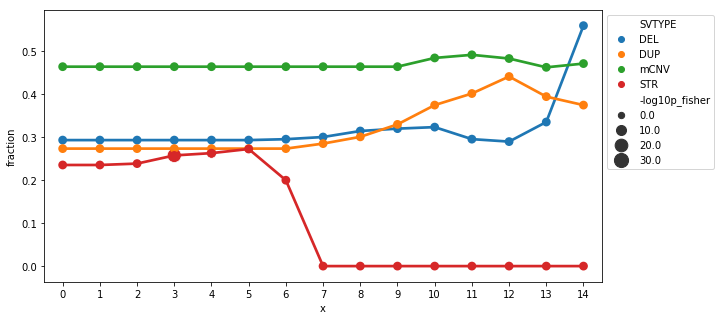

In [280]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
sns.scatterplot(x = 'x', y = 'fraction', size = '-log10p_fisher', sizes=(40,200), hue = 'SVTYPE', 
                data = stats_length, ax = ax)
leg = ax.legend(bbox_to_anchor = (1,1), loc = 'upper left')
ax.add_artist(leg)

sns.pointplot(x = 'x', y = 'fraction',hue = 'SVTYPE', 
                data = stats_length, ax = ax, s= 0, legend = False)

ax.legend().set_visible(False)
# ax.legend(bbox_to_anchor = (1,1), loc = 'upper left')

In [360]:
2777/7915

0.35085281111813016